In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import xgboost as xgb

/home/sgu/miniconda2/envs/GAPM/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
df_properties_2016 = pd.read_csv("properties_2016.csv")
df_train_2016 = pd.read_csv("train_2016_v2.csv")
df_properties_2016.shape, df_train_2016.shape

((2985217, 58), (90275, 3))

In [6]:
df = pd.merge?

In [7]:
df = df_train_2016.merge(df_properties_2016, on='parcelid')
df.shape

(90275, 60)

In [15]:
zip(np.percentile(np.abs(df.logerror.values),range(0,101,10)),range(0,101,10))

[(0.0, 0),
 (0.0050000000000000001, 10),
 (0.0109, 20),
 (0.016899999999999998, 30),
 (0.024299999999999999, 40),
 (0.032500000000000001, 50),
 (0.044000000000000004, 60),
 (0.058299999999999991, 70),
 (0.0843, 80),
 (0.14499999999999999, 90),
 (4.7370000000000001, 100)]

In [39]:
df_x = df.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'],axis=1)
df_y = df['logerror']
df_x.shape, df_y.shape

((90275, 55), (90275,))

In [40]:
sel = df_x.dtypes == object
cols_obj = df_x.dtypes[sel].index.values
df_x[cols_obj].apply(lambda s: dict(s.value_counts()), axis=0)

hashottuborspa        {True: 2365}
fireplaceflag          {True: 222}
taxdelinquencyflag    {u'Y': 1783}
dtype: object

In [41]:
for c in cols_obj: 
    df_x[c] = (df_x[c] == True) | (df_x[c]=='Y')

In [42]:
df_x.dtypes.value_counts()

float64    52
bool        3
dtype: int64

In [59]:
t = np.random.rand(len(df_x))
sel_train = t <0.7
sel_valid = np.logical_and(t>=0.7, t<0.9) 
sel_test = np.logical_and(~sel_train,~sel_valid)
df_x_train, df_x_valid, df_x_test = df_x[sel_train], df_x[sel_valid], df_x[sel_test]
df_y_train, df_y_valid, df_y_test = df_y[sel_train], df_y[sel_valid], df_y[sel_test]
df_x_train.shape, df_y_train.shape, df_x_valid.shape, df_y_valid.shape, df_x_test.shape, df_y_test.shape

((63045, 55), (63045,), (18222, 55), (18222,), (9008, 55), (9008,))

In [60]:
d_train = xgb.DMatrix(df_x_train, label=df_y_train.values)
d_valid = xgb.DMatrix(df_x_valid, label=df_y_valid.values)
d_test = xgb.DMatrix(df_x_test, label=df_y_test.values)
d_train.num_row(), d_train.num_col(),d_valid.num_row(), d_valid.num_col(), d_test.num_row(), d_test.num_col()

(63045L, 55L, 18222L, 55L, 9008L, 55L)

In [63]:
params = {
    'eta': 0.02, #step size shrinkage
    'objective':'reg:linear',
    'max_depth': 4, 
    'subsample': 0.8, #select 80% samples to build a tree each round 
    'eval_metric': 'mae',#mean absolute error
    'silent':1  #turn off verbose
}

In [66]:
gbm = xgb.train(params,d_train, num_boost_round=1000, evals=[(d_train,'train'),(d_valid,'test')],
                early_stopping_rounds=100,  #eval metric has to decrease every 100 rounds for d_valid
                verbose_eval=10, #print eval metrics every 10 rounds
               )

[0]	train-mae:0.487043	test-mae:0.487023
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 100 rounds.
[10]	train-mae:0.401235	test-mae:0.401579
[20]	train-mae:0.331727	test-mae:0.332395
[30]	train-mae:0.275618	test-mae:0.276566
[40]	train-mae:0.23045	test-mae:0.231649
[50]	train-mae:0.194254	test-mae:0.195755
[60]	train-mae:0.165352	test-mae:0.167114
[70]	train-mae:0.14238	test-mae:0.144328
[80]	train-mae:0.12427	test-mae:0.126319
[90]	train-mae:0.110142	test-mae:0.112211
[100]	train-mae:0.099226	test-mae:0.101312
[110]	train-mae:0.090877	test-mae:0.093021
[120]	train-mae:0.084592	test-mae:0.086769
[130]	train-mae:0.079916	test-mae:0.082099
[140]	train-mae:0.076492	test-mae:0.078691
[150]	train-mae:0.07397	test-mae:0.076209
[160]	train-mae:0.072152	test-mae:0.074419
[170]	train-mae:0.070824	test-mae:0.073106
[180]	train-mae:0.069866	test-mae:0.072171
[190]	train-mae:0.069159	test-mae:0.071487
[200]	train-m

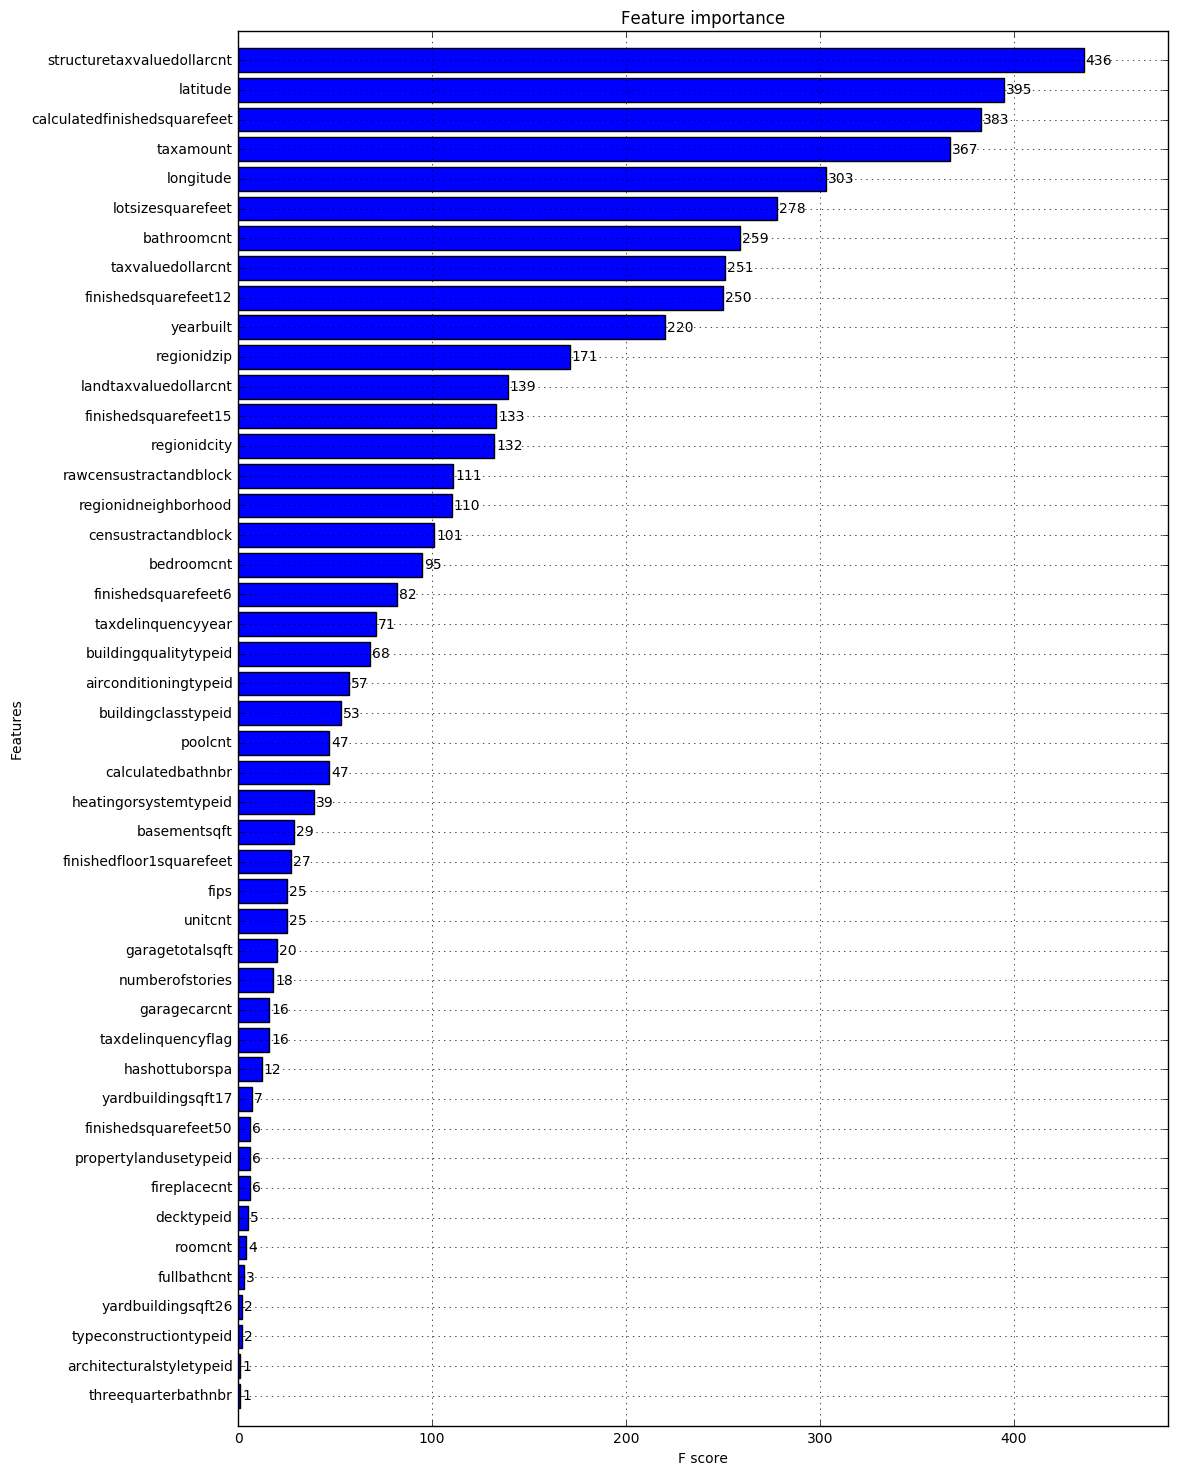

In [71]:
fig,ax = plt.subplots(figsize=(12,18)) #12in-by-12in image, otherwise legend overlaps. 
xgb.plot_importance(gbm,height=0.8, ax=ax)
plt.show()

In [88]:
#predict
y_test_pred= gbm.predict(d_test)
y_train_pred = gbm.predict(d_train)
y_valid_pred = gbm.predict(d_valid)

In [89]:
y_test_true=df[sel_test].logerror.values
y_train_true=df[sel_train].logerror.values
y_valid_true=df[sel_valid].logerror.values

In [84]:
y_mean = df_y_train.mean()
y_mean

0.011392380045998889

In [90]:
#calculate r2; very low!
r2_test = 1.0- np.sum((y_test_true - y_test_pred)**2)/np.sum((y_test_true-y_mean)**2)
r2_train = 1.0- np.sum((y_train_true - y_train_pred)**2)/np.sum((y_train_true-y_mean)**2)
r2_valid = 1.0- np.sum((y_valid_true - y_valid_pred)**2)/np.sum((y_valid_true-y_mean)**2)
r2_train, r2_valid, r2_test

(0.077192208895162762, 0.0099057921907748092, 0.01899080876369974)

In [93]:
# try to use mae 
f_mae = lambda x: np.median(np.abs(x))
r_test = 1.0- f_mae(y_test_true - y_test_pred)/f_mae(y_test_true-y_mean)
r_train = 1.0- f_mae(y_train_true - y_train_pred)/f_mae(y_train_true-y_mean)
r_valid = 1.0- f_mae(y_valid_true - y_valid_pred)/f_mae(y_valid_true-y_mean)
r_train, r_valid, r_test

(-0.011728941551367278, -0.015795287378766343, -0.012627379145943252)